In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

In [9]:
file_path =r'../data/fixed_data.csv'

df = pd.read_csv(file_path)

In [10]:
# Load data into pandas DataFrame
original_data = pd.read_csv('../data/Student data.csv',skiprows=24, header=None)

In [11]:
# Convert data to DataFrame
original_data = pd.DataFrame(original_data )
columns = ['firstTermGpa', 'secondTermGpa', 'firstLanguage', 'funding', 'school', 'fastTrack', 'coop', 'residency',
           'gender', 'previousEducation', 'ageGroup', 'highSchoolAverageMark', 'mathScore', 'englishScore', 'firstYearPersistence']
original_data.columns = columns

In [12]:
df['firstYearPersistence'] = original_data['firstYearPersistence']

In [30]:
# Splitting data into features and target
X = df.drop(columns=['firstYearPersistence'])
y = df['firstYearPersistence']

In [31]:
print(y.value_counts())

firstYearPersistence
1    1138
0     299
Name: count, dtype: int64


In [32]:
# Applying Random Over-Sampling to balance the classes
ros = RandomOverSampler(random_state=45)
X_ros, y_ros = ros.fit_resample(X, y)

print("\nClass balance for 'FirstYearPersistence' after Random Over-Sampling:")
print(y_ros.value_counts())


Class balance for 'FirstYearPersistence' after Random Over-Sampling:
firstYearPersistence
1    1138
0    1138
Name: count, dtype: int64


In [37]:
kfold = KFold(n_splits=5, shuffle=True, random_state=45)

accuracy_per_fold = []
loss_per_fold = []
confusion_matrices = []
precision_recall_data = []

# Filepath for saving the model
best_model_filepath = "../models/preistance_model.keras"

In [39]:
from keras.regularizers import l2

# K-fold cross-validation
for fold, (train_index, val_index) in enumerate(kfold.split(X_ros), start=1):
    X_train, X_val = X_ros.iloc[train_index], X_ros.iloc[val_index]
    y_train, y_val = y_ros.iloc[train_index], y_ros.iloc[val_index]


    # Model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    # Compiler
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    # ModelCheckpoint callback
    modelCheckpoint = ModelCheckpoint(
        filepath=best_model_filepath,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=0)
    #EarlyStopping callback
    earlyStopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True,

    )

    # Training
    model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=128,
        validation_data=(X_val, y_val),
        callbacks=[modelCheckpoint, earlyStopping],
        verbose=1)

    # Evaluate the model using scaled validation data
    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
    accuracy_per_fold.append(accuracy)
    loss_per_fold.append(loss)
    print(f'Fold {fold} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

    # Predict with the best model saved during training
    best_model = load_model(best_model_filepath)
    y_pred = (best_model.predict(X_val) > 0.5).astype(int)

    cm = confusion_matrix(y_val, y_pred)
    confusion_matrices.append(cm)
    
    # Precision-Recall Curve
    y_probs = best_model.predict(X_val)
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_probs)
    precision_recall_data.append((precisions, recalls, thresholds))


Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6818 - loss: 1.7884 - val_accuracy: 0.7610 - val_loss: 1.4337
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7803 - loss: 1.3670 - val_accuracy: 0.7982 - val_loss: 1.1612
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7983 - loss: 1.1239 - val_accuracy: 0.7829 - val_loss: 0.9850
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8061 - loss: 0.9462 - val_accuracy: 0.7982 - val_loss: 0.8702
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8120 - loss: 0.8469 - val_accuracy: 0.8048 - val_loss: 0.7820
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8210 - loss: 0.7554 - val_accuracy: 0.8114 - val_loss: 0.7221
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8415 - loss: 0.6697 - val_accuracy: 0.8289 - val_loss: 0.6556
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8489 - loss: 0.6272 - val_accuracy: 0.

In [40]:
# Calculate and print the mean accuracy and loss across all folds
mean_accuracy = np.mean(accuracy_per_fold)
mean_loss = np.mean(loss_per_fold)
print(f'\nMean Accuracy: {mean_accuracy:.4f}, Mean Loss: {mean_loss:.4f}')


Mean Accuracy: 0.9103, Mean Loss: 0.3894


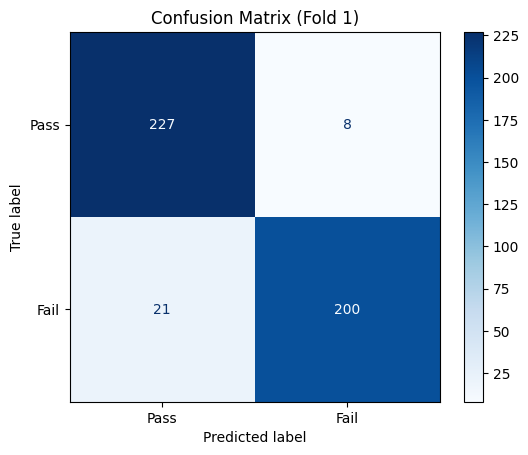

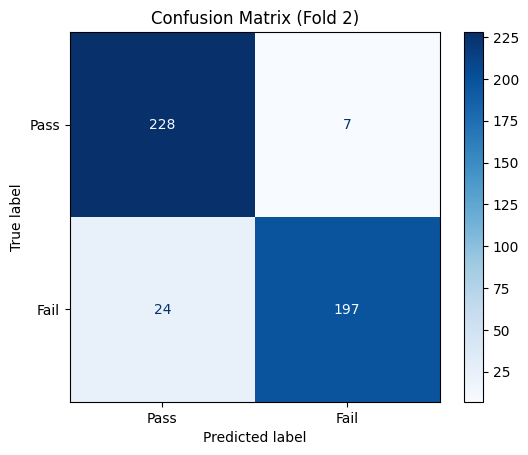

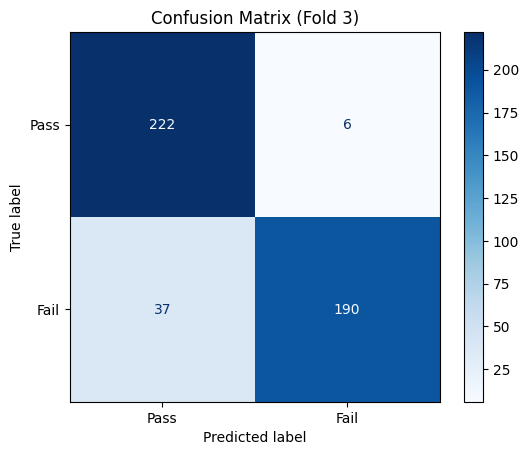

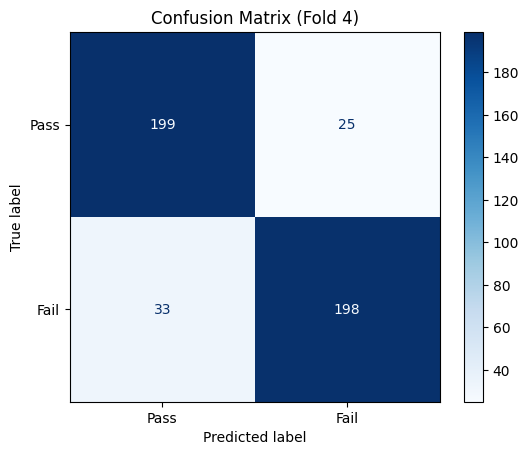

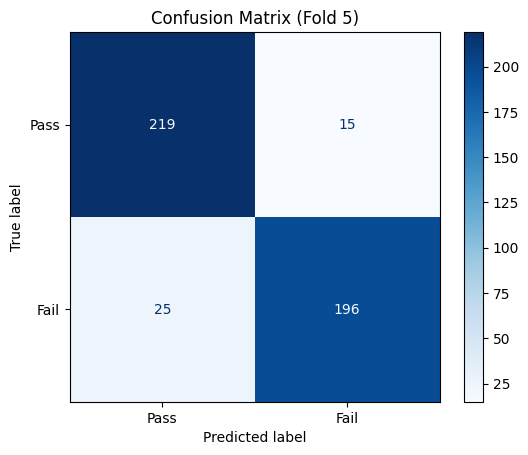

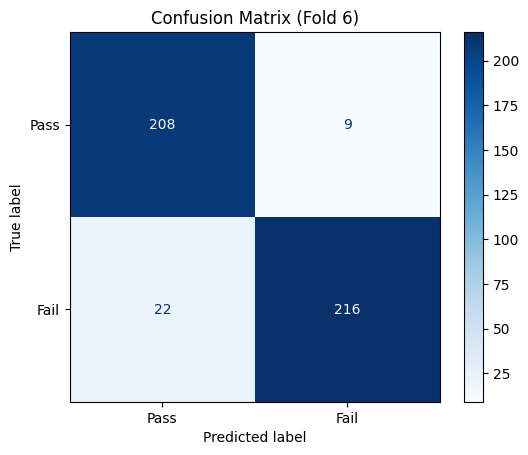

In [ ]:

import matplotlib.pyplot as plt

# Iterate through all folds and plot the confusion matrix for each
for i, cm in enumerate(confusion_matrices, start=1):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Pass', 'Fail'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix (Fold {i})')
    #plt.savefig(f'confusion_matrix_fold_{i}.png', dpi=300, bbox_inches='tight')
    plt.show()

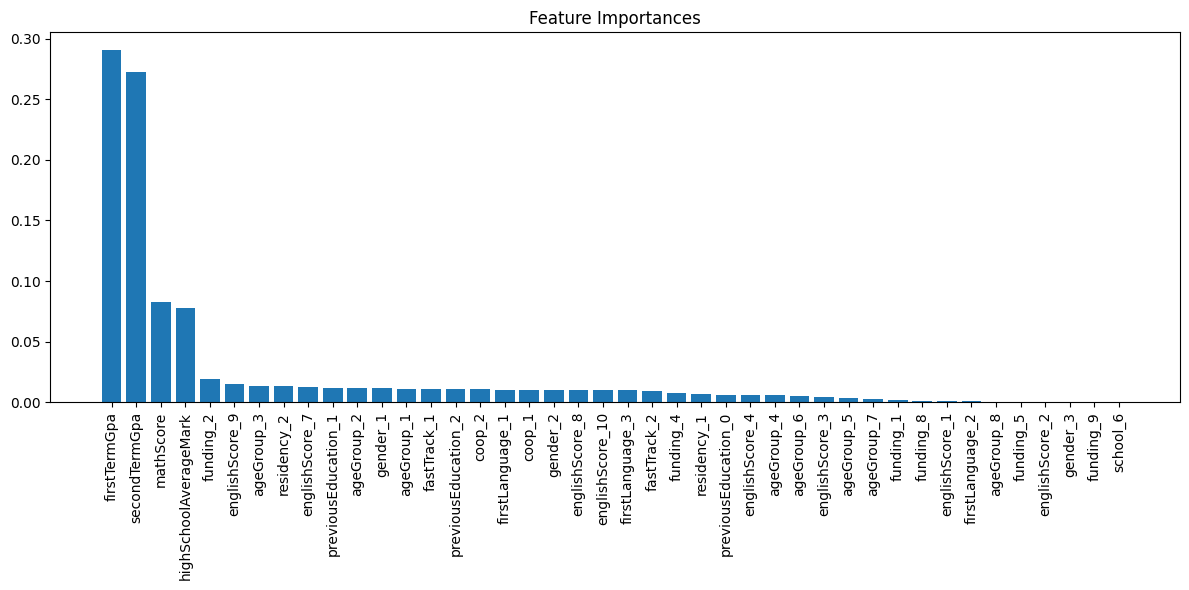

In [42]:
# Train a simple RandomForest model to analyze feature importance
rf = RandomForestClassifier(random_state=45)
rf.fit(X_ros, y_ros)

# Get feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(X_ros.shape[1]), importances[indices], align='center')
plt.xticks(range(X_ros.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

Accuracy Across Folds: Mean = 0.9103, Std = 0.0298, Min = 0.8484, Max = 0.9364
Loss Across Folds: Mean = 0.3894, Std = 0.0650, Min = 0.3317, Max = 0.4850


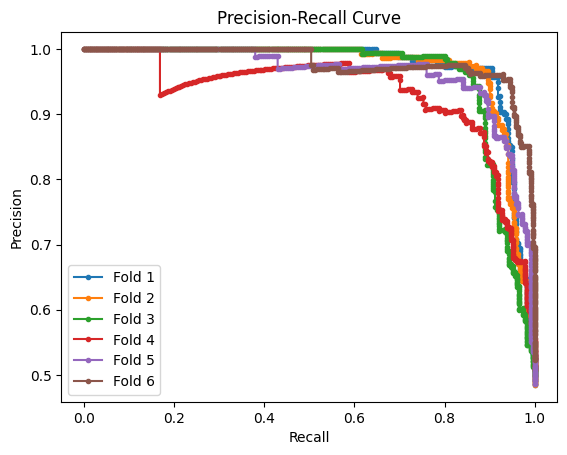

In [ ]:
mean_accuracy = np.mean(accuracy_per_fold)
std_accuracy = np.std(accuracy_per_fold)
min_accuracy = np.min(accuracy_per_fold)
max_accuracy = np.max(accuracy_per_fold)

mean_loss = np.mean(loss_per_fold)
std_loss = np.std(loss_per_fold)
min_loss = np.min(loss_per_fold)
max_loss = np.max(loss_per_fold)

print(f"Accuracy Across Folds: Mean = {mean_accuracy:.4f}, Std = {std_accuracy:.4f}, Min = {min_accuracy:.4f}, Max = {max_accuracy:.4f}")
print(f"Loss Across Folds: Mean = {mean_loss:.4f}, Std = {std_loss:.4f}, Min = {min_loss:.4f}, Max = {max_loss:.4f}")

for i, (precisions, recalls, thresholds) in enumerate(precision_recall_data, start=1):
    plt.plot(recalls, precisions, marker='.', label=f'Fold {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
#plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()
